# 15. First 3-class Runs on Extra Data
## Run Details:
- Dataset: just extra
- Test Goals: compare effects of barrel fix and transforms
- Results Summary: 

In [1]:
import sys
import os
import h5py
from collections import Counter
from progressbar import *
import re
import numpy as np
import itertools
from tqdm import tqdm

par_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))

if par_dir not in sys.path:
    sys.path.append(par_dir)
    
from repeating_classifier_training_utils import *

%load_ext autoreload
%matplotlib inline
%autoreload 2

## Set Run Directories Here

In [2]:
dump_dir = '/home/cmacdonald/CNN/dumps/'

paths = ['20200806_174110_3class_fulldset_notransforms',
         '20200807_212816_3class_fulldset_transforms',
         '20200810_115943_3class_fulldset_weighted_notransforms',
         '20200812_060029_3class_fulldset_weighted_transforms']

paths = [os.path.join(dump_dir,path) for path in paths]
preferred_run_idx = 1
run_names=['Full Dataset, No Transforms', 'Full Dataset, Transforms', 'Full Dataset, Weighted, \n No Transforms',
           'Full Dataset, Weighted, \n Transforms']
cut_names= [['fq_failed', 'fq_flag'] for _ in range(4)]


idx_file_paths = ['/fast_scratch/WatChMaL/data/IWCD_fulltank_300_pe_idxs_extra.npz' for _ in range(4)]

npz_path = os.path.join(os.getcwd(),'Index_Storage')

LABEL_DICT = {0:"gamma", 1:"e", 2:"mu"}
softmax_index_dict = {value:key for key, value in LABEL_DICT.items()}

## Plot Training History

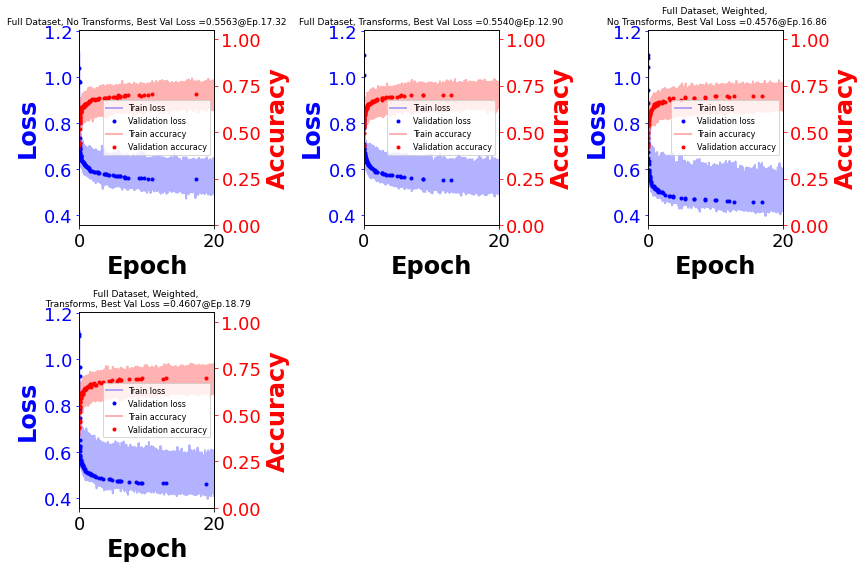

In [3]:
fig = disp_multiple_learn_hist(paths,losslim=None,titles=run_names,leg_font=8, title_font=9, best_only=True)

## Plot Confusion Matrices

In [4]:
test_output = [load_test_output_pn(os.path.join(loc,'test_validation_iteration_dump.npz'),os.path.join(os.getcwd(),'Pointnet_Cut_Indices/pointnet_cut_indices.npz'),np.load(idx_file_paths[i])['test_idxs'], cut_names[i]) 
               for i,loc in enumerate(paths)]

<Figure size 432x288 with 0 Axes>

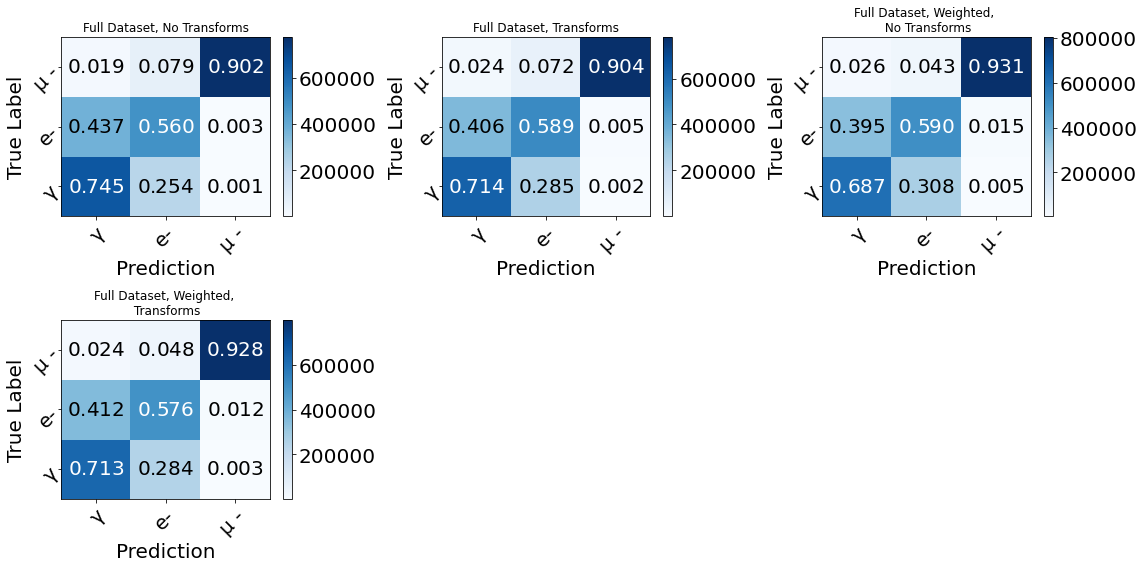

In [5]:
plt.clf()
fig=plot_multiple_confusion_matrix([output['labels'] for output in test_output], [output['predicted_labels'] for output in test_output],
                               ['\u03B3','e-','\u03BC -'],titles=run_names)

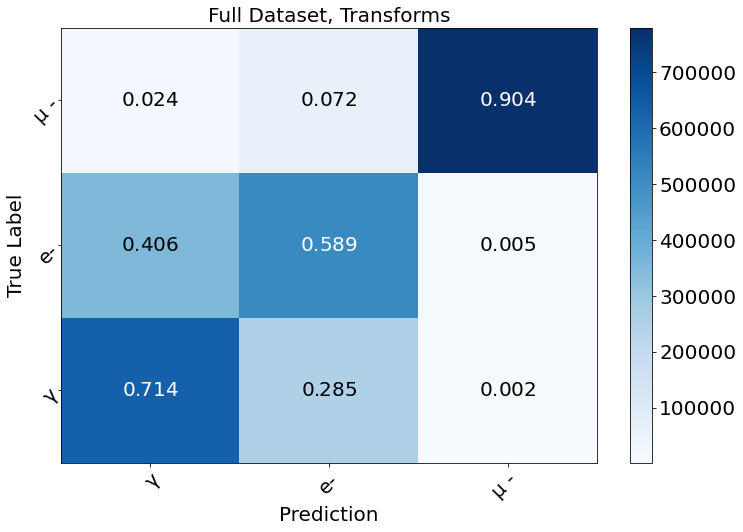

In [6]:
preferred_run=test_output[preferred_run_idx]
plot_confusion_matrix(preferred_run['labels'],preferred_run['predicted_labels'],['\u03B3','e-','\u03BC -'],title=run_names[preferred_run_idx])


In [7]:
print(f"Gamma Events: {np.where(preferred_run['labels']==0)[0].shape[0]} e- Events: {np.where(preferred_run['labels']==1)[0].shape[0]} mu- Events: {np.where(preferred_run['labels']==2)[0].shape[0]}")

Gamma Events: 886037 e- Events: 865453 mu- Events: 861804


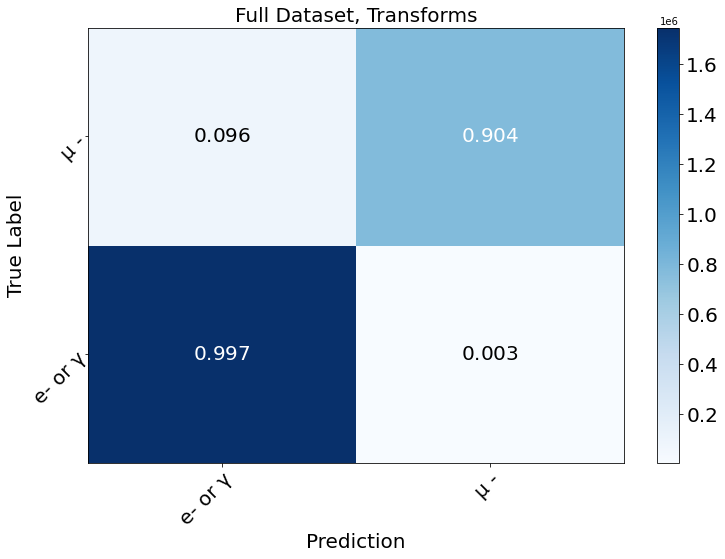

In [8]:
collapsed_sm_1, collapsed_labels_1, collapsed_predictions_1= collapse_test_output(preferred_run['softmax'],
                                                                 preferred_run['labels'],
                                                                 softmax_index_dict,
                                                                 predictions = preferred_run['predicted_labels'])
fig = plot_confusion_matrix(collapsed_labels_1-1,collapsed_predictions_1-1,
                            ['e- or \u03B3','\u03BC -'],title=run_names[preferred_run_idx])

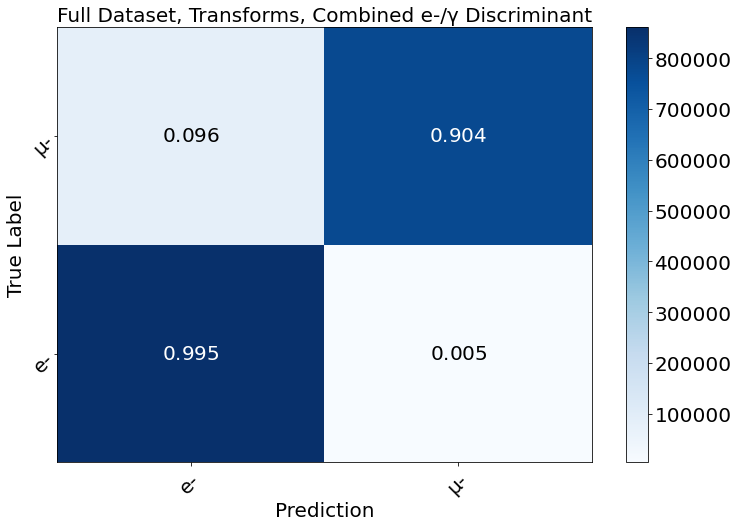

In [9]:
collapsed_sm_1, collapsed_labels_1, collapsed_predictions_1= collapse_test_output(preferred_run['softmax'],
                                                                 preferred_run['labels'],
                                                                 softmax_index_dict,
                                                                 predictions = preferred_run['predicted_labels'])
emu_idxs = np.where(preferred_run['labels']!=0)[0]
fig = plot_confusion_matrix(collapsed_labels_1[emu_idxs]-1,collapsed_predictions_1[emu_idxs]-1,
                            ['e-','\u03BC-'],title=f'{run_names[preferred_run_idx]}, Combined e-/\u03B3 Discriminant')

## ROC Curves

### P(e), e-mu

In [10]:
fprs, tprs, thresholds = zip(*[prep_roc_data(output['softmax'],output['labels'],
                                'rejection',softmax_index_dict,"e","mu",energies=output['energies'],) for output in test_output]
                            )

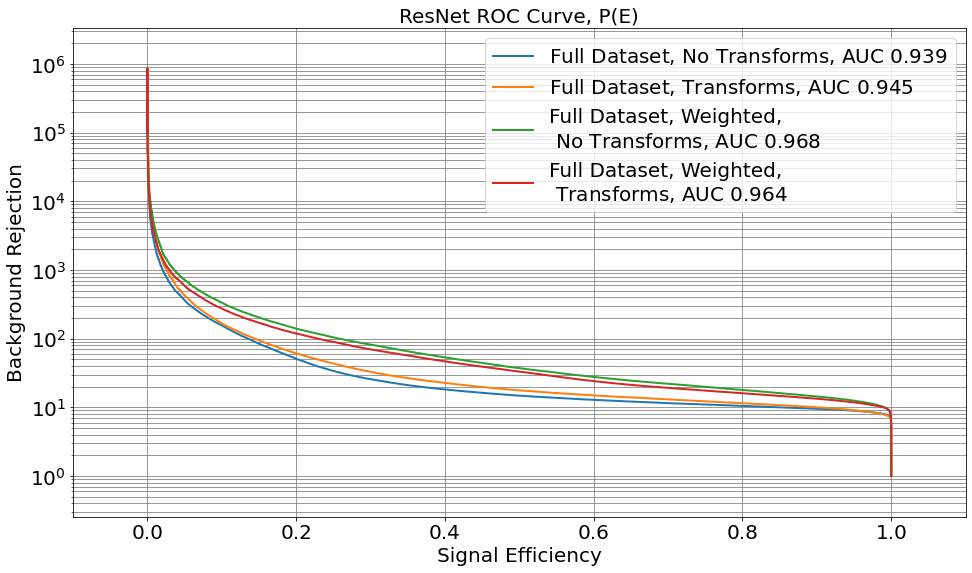

In [11]:
roc_metrics = plot_multiple_ROC((fprs, tprs, thresholds),'rejection', ["e", "mu"], 
                                plot_labels=run_names,
                                png_name = 'overlaid_roc',title='ResNet ROC Curve, P(E)',annotate=False)

### e-gamma

In [12]:
fprs, tprs, thresholds = zip(*[prep_roc_data(output['softmax'],output['labels'],
                                'rejection',softmax_index_dict,"e","gamma",energies=output['energies'],) for output in test_output]
                            )

In [13]:
print(len(fprs))

4


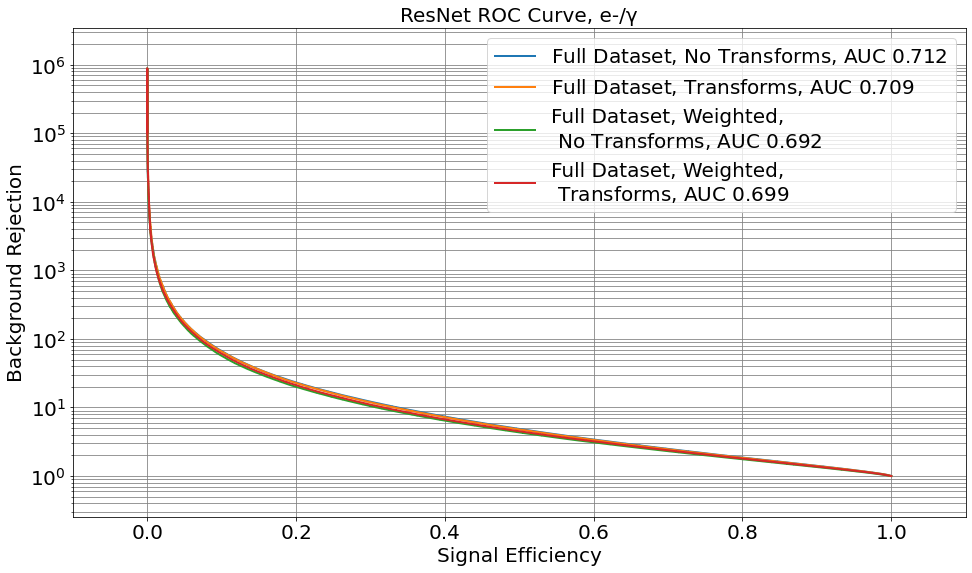

In [14]:
roc_metrics = plot_multiple_ROC((fprs, tprs, thresholds),'rejection', ["e", "gamma"], 
                                plot_labels=run_names,
                                png_name = 'overlaid_roc',title='ResNet ROC Curve, e-/\u03B3',annotate=False)

### P(e) + P(Gamma), e-mu

In [24]:
collapsed_outputs = [collapse_test_output(run['softmax'], run['labels'],
                                                                 softmax_index_dict, ignore_type="gamma") for run in test_output]

fprs, tprs, thresholds = zip(*[prep_roc_data(run[0],run[1],
                                'rejection',softmax_index_dict,"e","mu") for run in collapsed_outputs
                              ]
                            )

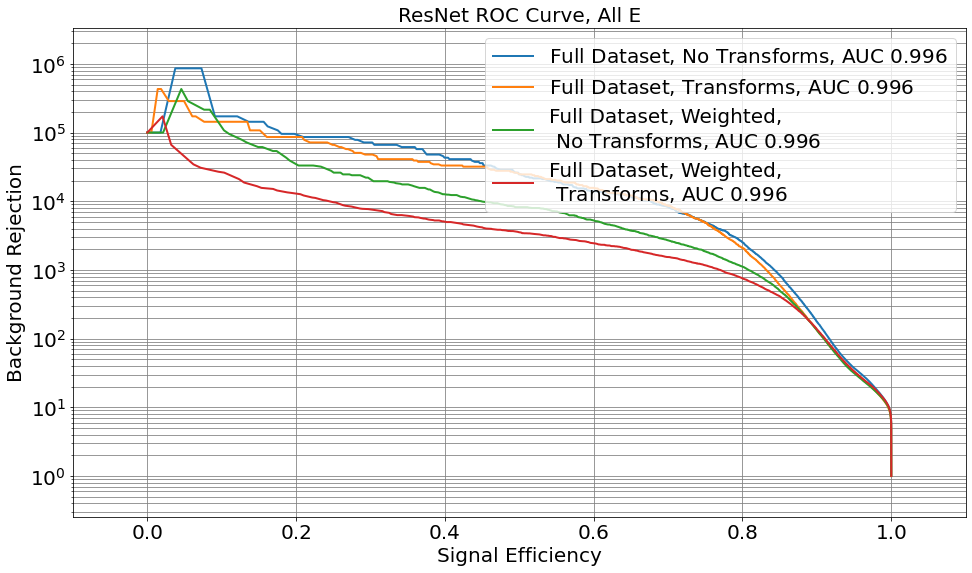

In [25]:
roc_metrics = plot_multiple_ROC((fprs, tprs, thresholds),'rejection', ["e", "mu"], 
                                plot_labels=run_names,
                                png_name = 'overlaid_roc',title='ResNet ROC Curve, All E',annotate=False)

In [17]:
fq_rootfiles, fq_eventids, fq_flag, fq_scores, fq_mom, fq_labels = load_fq_output(os.path.join(npz_path,'fq_mapping_idxs.npz'), os.path.join(npz_path,'fq_failed_idxs.npz'), idx_file_paths[0], os.path.join(os.getcwd(),'Pointnet_Cut_Indices/pointnet_cut_indices.npz'), cut_names[0])

In [18]:
pbar = ProgressBar(widgets=['Verification Progress: ', Percentage(), ' ', Bar(marker='0',left='[',right=']'),
           ' ', ETA()], maxval=len(fq_rootfiles))
pbar.start()
for i in range(len(fq_rootfiles)):
    assert re.sub('_fiTQun','',fq_rootfiles[i].split('/')[-1]) == preferred_run['rootfiles'][i].split('/')[-1], print(fq_rootfiles[i])
    assert fq_eventids[i] -1 == preferred_run['eventids'][i]
    pbar.update(i)
pbar.finish()
assert len(preferred_run['rootfiles']) == fq_rootfiles.shape[0]
print("Success! We now have a FiTQun output set in the same order as the h5 test set")

Success! We now have a FiTQun output set in the same order as the h5 test set


In [19]:
collapsed_sm_1, collapsed_labels_1 = collapse_test_output(preferred_run['softmax'],
                                                                 preferred_run['labels'],
                                                                 softmax_index_dict, ignore_type="gamma")
fprs, tprs, thresholds = zip(*[prep_roc_data(preferred_run['softmax'],preferred_run['labels'],
                                'rejection',softmax_index_dict,"e","mu"),
                                prep_roc_data(collapsed_sm_1,collapsed_labels_1, 'rejection',softmax_index_dict, "e","mu"),
                                prep_roc_data(fq_scores,fq_labels,'rejection',softmax_index_dict,"e","mu")
                              ]
                            )

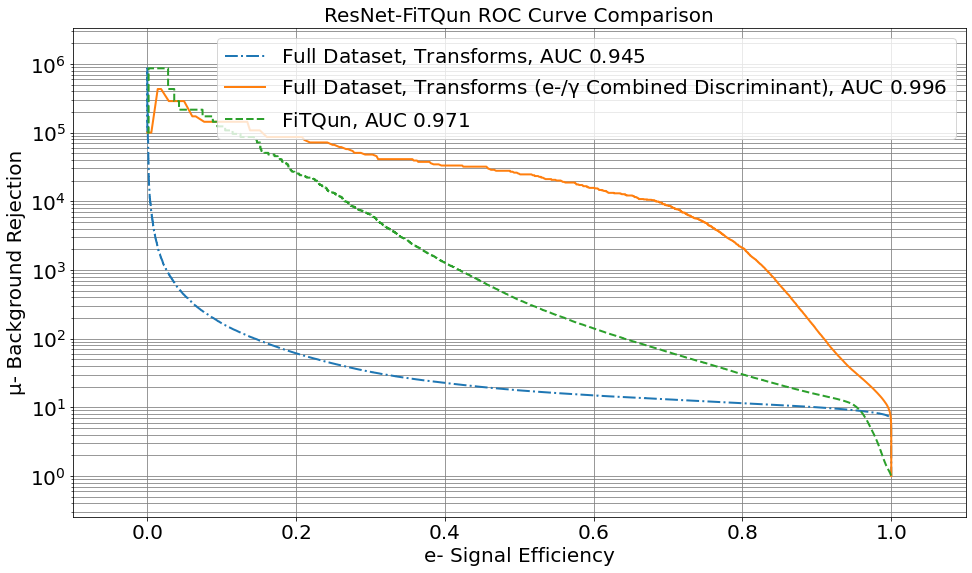

In [20]:
roc_metrics = plot_multiple_ROC((fprs, tprs, thresholds),'rejection', [["e", "mu"],['e','mu'],['e','mu']], 
                                plot_labels = [f'{run_names[preferred_run_idx]}', f'{run_names[preferred_run_idx]} (e-/\u03B3 Combined Discriminant)','FiTQun'],
                                png_name = 'overlaid_roc',title='ResNet-FiTQun ROC Curve Comparison',annotate=False,
                                linestyle=('dashdot','-','--'), xlabel='e- Signal Efficiency',ylabel='\u03BC- Background Rejection')
# plt.savefig(os.path.join(os.getcwd(),'plot_images/ROC_comparison.pdf'))